In [4]:
import pypsa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from syntheticdemand import syntheticdemand, vres_capacity
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
from capacityfactors import res_capacity
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Interconnectors

### Calculation of distances between nodes

In [4]:
# Create a Geod object for the WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Function that calculates the distance between two nodes
def calculate_distance(bus0, bus1):
    """Calculates the actual distance between two points on the earth.

    Args:
        node1 (int): Identifier of bus 0
        node2 (int): Identifier of bus 1

    Returns:
        float: Distance between the two nodes in km.
    """
    lon1, lat1 = regions_dic[bus0]["coordinates"]
    lon2, lat2 = regions_dic[bus1]["coordinates"]
    _, _, distance = geod.inv(lon1, lat1, lon2, lat2)
    return distance / 1000

# Compute the lengths of the interconnectors and store in dictionary
for key, value in links_dic.items():
    value["length"] = calculate_distance(value["bus0"][0], value["bus1"][0])


### Calculation of efficiency

In [3]:
def efficiency_link(P, V, rho, l):
    """Calculates the relative losses of each interconnector.

    Args:
        P (float): Power capacity of cable in MW
        V (float): Cable volatge in kV 
        rho (float): Resisitivity of cable in ohms/km
        l (float): length of cable in km

    Returns:
        float: Efficiency of the cable 
    """
    I = P / V * 1000 # Current in amperes (A)
    R = rho * l # Resistance in ohms 
    losses = I**2 * R * 1e-6 # total losses in MW
    efficiency =  1 - losses / P # Efficiency of the cable

    return efficiency

# Compute the efficiency of the interconnectors and store in dictionary
cable_capacity = 1200 # Capacity of cable in MW
cable_voltage = 1100 # Voltage of cable in kV
cable_resistivity = 0.01286 # Resistivity of the cable in ohms/km
converter_losses = 0.015 # rlative losses for the converter pair
for key, value in links_dic.items():
    value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

### Synthetic demand

In [8]:
path = "/Volumes/PJB1008_2/synde/resources/gegis/output"
res_potential_dic = {}
load_profile_dic = {}
for key, value in regions_dic.items():
    region = value["region"]
    load_profile_dic[key] = {}
    load_profile_dic[key]["region"] = region
    if region != "north_america" and region != "europe" and region != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand(path, region, "ssp1-26" )

### Capacity factors

# PyPSA 

### Create the grid (actual grid)

In [ ]:
# Initialise the network
globalgrid = pypsa.Network() 

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    globalgrid.add(class_name = "Bus", name = value["region"], v_nom=f'{cable_voltage}', carrier = "DC", v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05,x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links
for key, value in links_dic.items():
    globalgrid.add(class_name="Link", name=value["name"], bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=0, p_min_pu=-1, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    globalgrid.add(class_name="Generator", name=f'windonshore {value["region"]}', type="Wind", bus=value["region"], p_nom_extendable = True, p_nom_max=value["windonshore"],p_nom_min=value["windonshore"], marginal_cost = 1)
    globalgrid.add(class_name="Generator", name=f'windoffshore {value["region"]}', type="Wind", bus=value["region"], p_nom_extendable = True, p_nom_max=value["windoffshore"],p_nom_min=value["windoffshore"], marginal_cost = 1)
    globalgrid.add(class_name="Generator", name=f'pv {value["region"]}', type="PV", bus=value["region"], p_nom_extendable = True, p_nom_max=value["pv"],p_nom_min=value["pv"], marginal_cost = 1)
    globalgrid.add(class_name="Generator", name=f'curtailment {value["region"]}', type="PV", bus=value["region"], p_nom_extendable = True, marginal_cost = 0, sign=-1)


# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    globalgrid.add(class_name="Load", name=f"{value["region"]}", bus=value["region"], p_set=value["load"])
    

### Create a grid with example data

In [13]:
np.random.seed(42)
time_series = pd.date_range("2023-01-01 00:00", "2023-12-31 23:00", freq="h")
def test_series(lower, upper, time_series):
    random_data = np.random.uniform(lower, upper, size=len(time_series))
    return pd.Series(random_data, index=time_series)

# Generate 13 series
demand_test_list = [test_series(30, 100, time_series) for _ in range(14)]
wind_test_list = [test_series(0, 150, time_series) for _ in range(14)]
pv_test_list = [test_series(0, 150, time_series) for _ in range(14)]

deficits = []

for i in range(14):
    deficit = wind_test_list[i] + pv_test_list [i] - demand_test_list[i]
    deficits.append(deficit)

global_deficit =  pd.concat(deficits, axis=1).sum(axis=1)


In [14]:
demand_test_list[0]

2023-01-01 00:00:00    56.217808
2023-01-01 01:00:00    96.550001
2023-01-01 02:00:00    81.239576
2023-01-01 03:00:00    71.906094
2023-01-01 04:00:00    40.921305
                         ...    
2023-12-31 19:00:00    89.823222
2023-12-31 20:00:00    46.134639
2023-12-31 21:00:00    52.929641
2023-12-31 22:00:00    44.692499
2023-12-31 23:00:00    64.431317
Freq: h, Length: 8760, dtype: float64

In [156]:
# Initialize the network
globalgrid = pypsa.Network()
globalgrid.set_snapshots(time_series)

# Add buses
for i in regions_dic:
    globalgrid.add("Bus", name=regions_dic[i]["region"], x=regions_dic[i]["coordinates"][0], y=regions_dic[i]["coordinates"][1])

# Add links
for key, value in links_dic.items():
    globalgrid.add("Link", name=value["name"], bus0=regions_dic[value["bus0"][0]]["region"], bus1=regions_dic[value["bus1"][0]]["region"], efficiency=value["efficiency"], marginal_cost=0, p_min_pu=-1, p_nom_max=np.inf, p_nom_extendable=True)

# Add generators
for i in regions_dic:
    globalgrid.add("Generator", name=f'wind {i}', carrier="wind", bus=regions_dic[i]["region"], p_nom_extendable=True,p_nom_max=1.0, p_max_pu=wind_test_list[i-1], p_min_pu=wind_test_list[i-1], marginal_cost=0)
    globalgrid.add("Generator", name=f'pv {i}', carrier="pv", bus=regions_dic[i]["region"], p_nom_extendable=True,p_nom_max=1.0, p_max_pu=pv_test_list[i-1], p_min_pu=pv_test_list[i-1], marginal_cost=0)
    globalgrid.add("Generator", name=f'curtailment {i}',carrier="curtailment", bus=regions_dic[i]["region"], p_nom_extendable=True, marginal_cost=100000, sign=-1)

# Add loads
for i in regions_dic:
    globalgrid.add("Load", f"load {i}", bus=regions_dic[i]["region"], p_set=demand_test_list[i-1])

### Solve the optmisation problem

In [157]:
# Optimize the grid
globalgrid.optimize(solver_name="highs")

# Print the results
#print(globalgrid.generators.p_nom_opt)
# print(globalgrid.links_t.p0)
# print(globalgrid.links_t.p1)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]
INFO:linopy.io: Writing time: 4.15s
INFO:linopy.solvers:Log file at /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/highs.log.


Running HiGHS 1.7.0 (git hash: 27ccfaa): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+02]
  Cost   [1e+05, 1e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+02]
Presolving model
613200 rows, 543148 cols, 1699440 nonzeros  0s
367920 rows, 543148 cols, 1208880 nonzeros  1s
122640 rows, 297868 cols, 718320 nonzeros  1s
Presolve : Reductions: rows 122640(-1086330); columns 297868(-245314); elements 718320(-2049930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 122640(203420); Du: 0(7.44518e-08) 2s
       3950     6.6161486462e-09 Pr: 118690(156832); Du: 0(6.96628e-08) 7s
       7871     9.9965272647e-09 Pr: 114769(142428); Du: 0(6.64782e-08) 12s
      11632     1.6912620052e-08 Pr: 111008(132651); Du: 0(6.39121e-08) 17s
      15381     2.7698284843e-08 Pr: 107259(125432); Du: 0(6.18858e-08) 23s
      19225     1.1606589634e-04 Pr: 103

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 543182 primals, 1208970 duals
Objective: 0.00e+00
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

## Extract all the relevant values

In [154]:
print(globalgrid.generators.p_nom_opt)

Generator
wind 1           -0.0
pv 1             -0.0
curtailment 1    -0.0
wind 2           -0.0
pv 2              1.0
curtailment 2    -0.0
wind 3           -0.0
pv 3             -0.0
curtailment 3    -0.0
wind 4           -0.0
pv 4             -0.0
curtailment 4    -0.0
wind 5           -0.0
pv 5             -0.0
curtailment 5    -0.0
wind 6           -0.0
pv 6             -0.0
curtailment 6    -0.0
wind 7           -0.0
pv 7             -0.0
curtailment 7    -0.0
wind 8           -0.0
pv 8             -0.0
curtailment 8    -0.0
wind 9           -0.0
pv 9              1.0
curtailment 9    -0.0
wind 10          -0.0
pv 10            -0.0
curtailment 10   -0.0
wind 11          -0.0
pv 11            -0.0
curtailment 11   -0.0
wind 12          -0.0
pv 12            -0.0
curtailment 12   -0.0
wind 13          -0.0
pv 13            -0.0
curtailment 13   -0.0
wind 14          -0.0
pv 14             1.0
curtailment 14   -0.0
Name: p_nom_opt, dtype: float64


In [ ]:
year = 2023
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = globalgrid.generators_t.p[f"{carrier} {key}"].max() # Installed capacities for each node in MW
        regions_dic[key][f"total_{carrier}_yearly"] = globalgrid.generators_t.p[f"{carrier} {key}"].sum(axis=0) / 1e6 # Total energy generated at each node in TWh
    
    regions_dic[key][f"total_curtailment_yearly"] = globalgrid.generators_t.p[f"curtailment {key}"].sum(axis=0) / 1e6 # Curtailment at each node in TWh
    regions_dic[key][f"total_load_yearly"] = globalgrid.loads_t.p[f"load {key}"].sum(axis=0)
 
for key, value in regions_dic.items():
    for carrier in ["pv", "wind"]:
        series_g = globalgrid.generators_t.p[f"{carrier} {key}"] 
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # MW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # MWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # MW

    series_c = globalgrid.generators_t.p[f"curtailment {key}"]
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # MW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # MWh

    series_l = globalgrid.loads_t.p[f"load {key}"]
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # MWh
    
    

# Daily hourly values of specific days
dates = pd.to_datetime([f"{year}-03-21", f"{year}-06-21", f"{year}-09-21", f"{year}-12-21"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = globalgrid.generators_t.p[f"{carrier} {key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = globalgrid.loads_t.p[f"load {key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day

        regions_dic[key][f"houtly_curtailment_{date}"] = globalgrid.generators_t.p[f"curtailment {key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day


### Link losses

In [ ]:
# Store hourly losses  for each link in dictionary
for link in links_dic:
    p0, p1 = globalgrid.links_t.p0[value["name"]], globalgrid.links_t.p1[value["name"]]
    abs_losses = abs(p0 + p1)
    active_power = pd.DataFrame({'p0': p0, 'p1': p1})
    p_trans = active_power.abs().max(axis=1)
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Sum the losses of the links
total_hourly_abs_losses = pd.Series(0, index=globalgrid.snapshots)
total_hourly_p_trans = pd.Series(0, index=globalgrid.snapshots)
for link in links_dic:
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

### Losses vs load

In [ ]:
# Sum loads of dictionaries
total_hourly_load = pd.Series(0, index=globalgrid.snapshots)
for key, value in regions_dic.items():
    total_hourly_load += globalgrid.loads_t.p[f"load {key}"]

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()

# Losses relative to load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

### Losses vs generation

In [ ]:
# Sum generation of nodes
total_hourly_gen = pd.Series(0, index=globalgrid.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += globalgrid.generators_t.p[f"wind {key}"] + globalgrid.generators_t.p[f"pv {key}"]

# Generation 
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Statistics of the losses
daily_deviation_gen = daily_losses_rel_to_gen - daily_losses_rel_to_gen.mean()
monthly_deviation_gen = monthly_losses_rel_to_gen - monthly_losses_rel_to_gen.mean()

In [ ]:
hourly_losses_rel_to_gen.max()

4.285300073977999

In [ ]:
flow = pd.Series(10, index=globalgrid.branches().index)

In [ ]:
gen = globalgrid.generators.assign(g=globalgrid.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
transmission = globalgrid.links.assign(g=globalgrid.links_t.p0.mean()).groupby(["Link"]).g.sum()

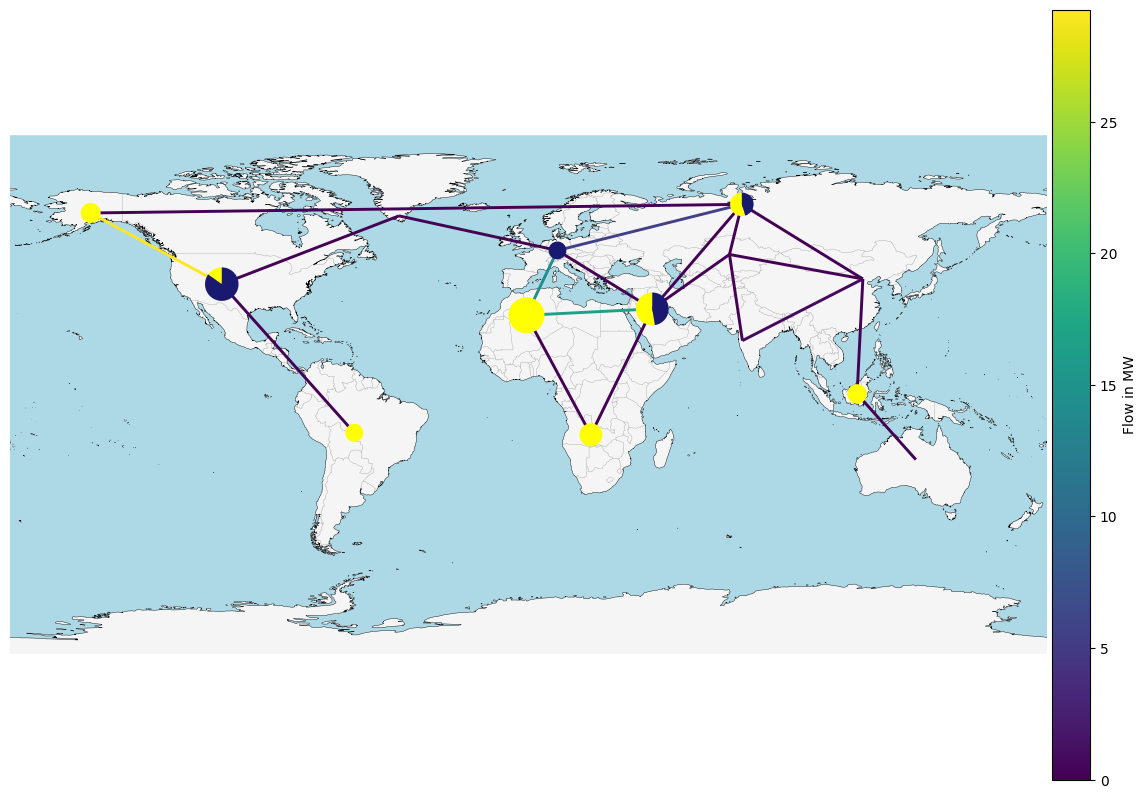

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors


# Plot the network with arrows indicating flow direction
collection = globalgrid.plot(
    bus_sizes=gen / 5,
    bus_colors={"wind": "midnightblue", "pv": "yellow", "curtailment": "red"},
    flow=flow,
    line_widths=2.7,
    link_widths=2.1,
    color_geomap=True,
    link_colors=globalgrid.links_t.p0.mean().abs(),
    boundaries=[-180, 180, -90, 90],
)
# Add colorbar for flow
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")

plt.show()


## Plotting of just the map

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_88499/879127582.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


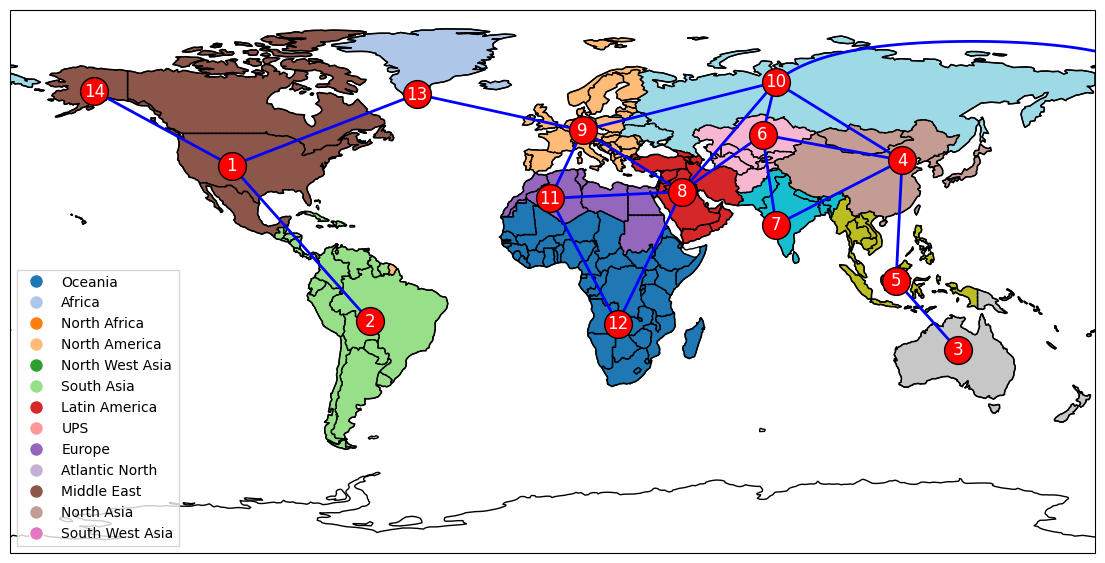

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Plot links
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]

    if link == "Alaska to UPS":  # Specifically handle the link from North America to UPS
        # Calculate points along the great circle
        points = geod.npts(x0, y0, x1, y1, 100)
        lons, lats = zip(*points)
        lons = [(lon + 360) % 360 if lon < 0 else lon for lon in lons]  # Ensure all longitudes are positive
        ax.plot(lons, lats, color='blue', linewidth=2, zorder=4)
    else:
        ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/4250610060.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


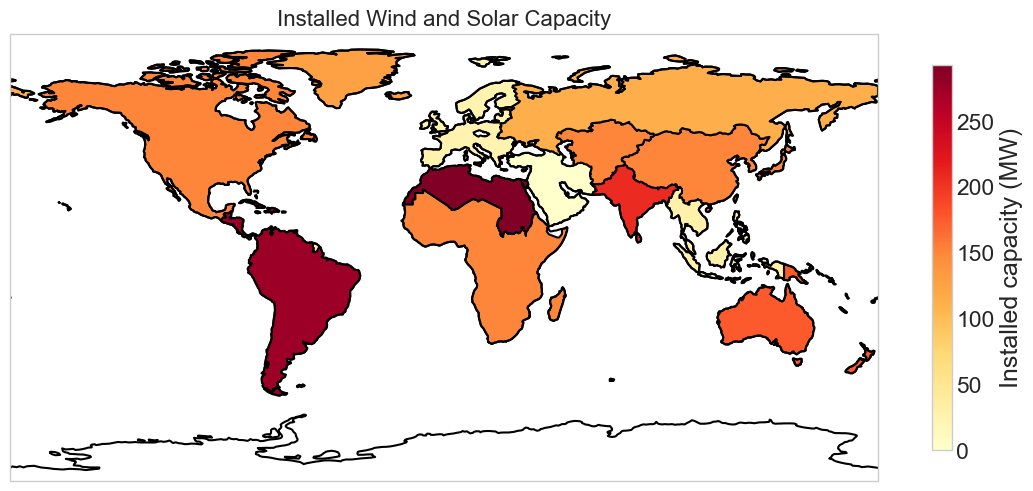

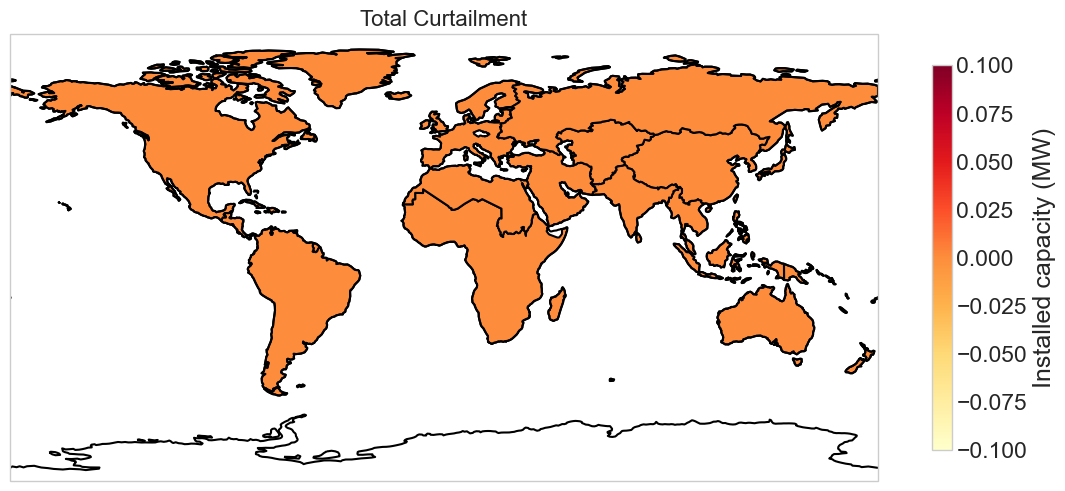

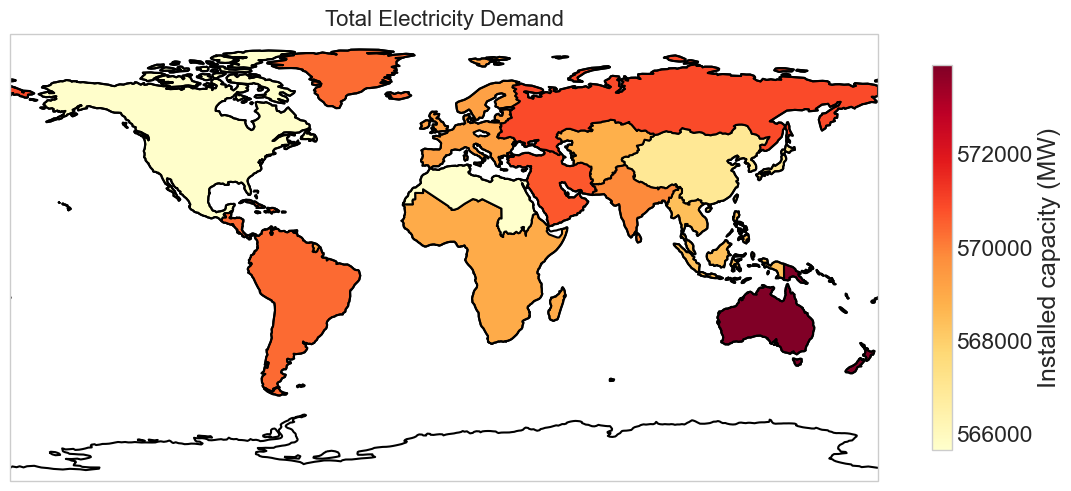

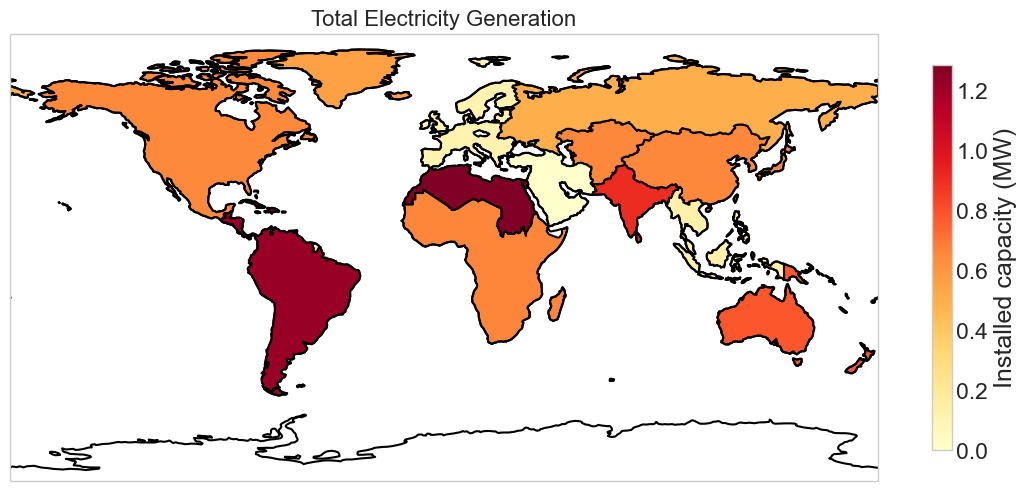

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_dic = {}
curtailment_dic = {}
loads_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    installed_capacity_dic[value["region"]] = value["wind_installed"] + value["pv_installed"]
    curtailment_dic[value["region"]] = value["curtailment_total"]
    loads_dic[value["region"]] = value["load_total"] 
    generation_dic[value["region"]] = value["wind_generation_total"] + value["pv_generation_total"]
values_dics = [installed_capacity_dic, curtailment_dic, loads_dic, generation_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(globalgrid.buses.index, start=1):
    #     x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind and Solar Capacity', fontsize=16)
    elif i == 1:
        plt.title('Total Curtailment', fontsize=16)
    elif i == 2:
        plt.title('Total Electricity Demand', fontsize=16)
    elif i == 3:
        plt.title('Total Electricity Generation', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Installed capacity (MW)')

    plt.show()

## Plotting of demand and supply graphs


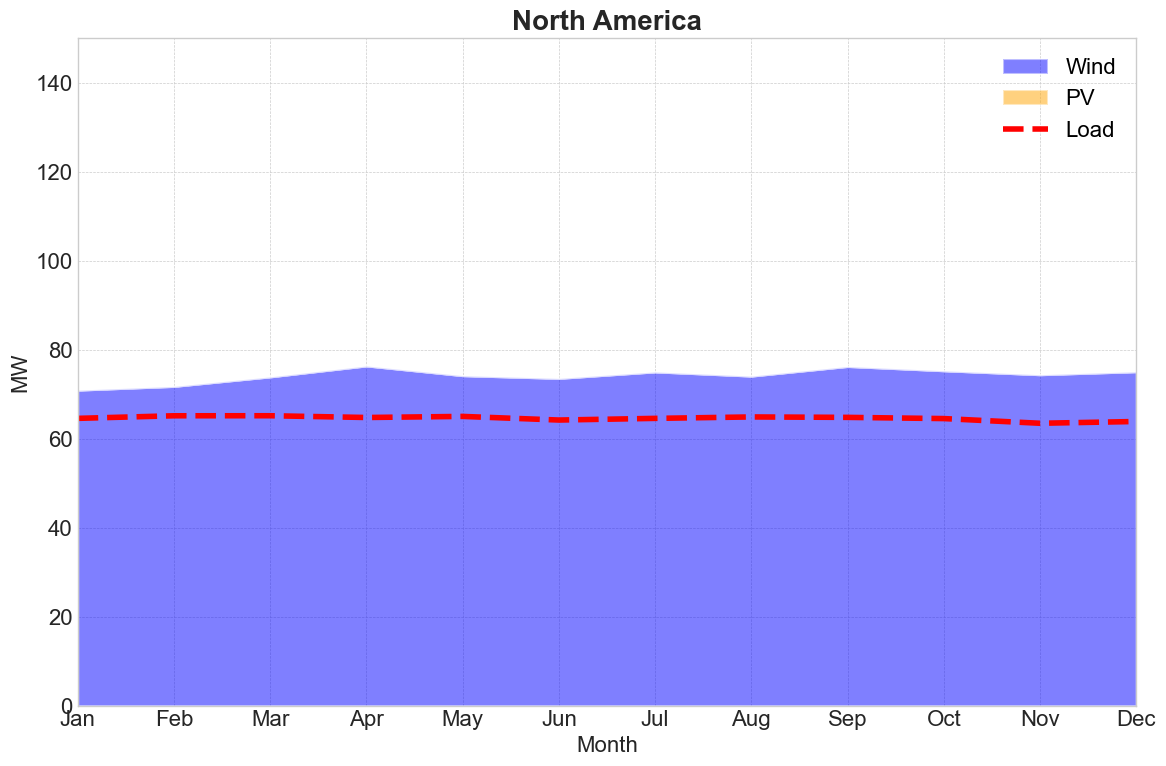

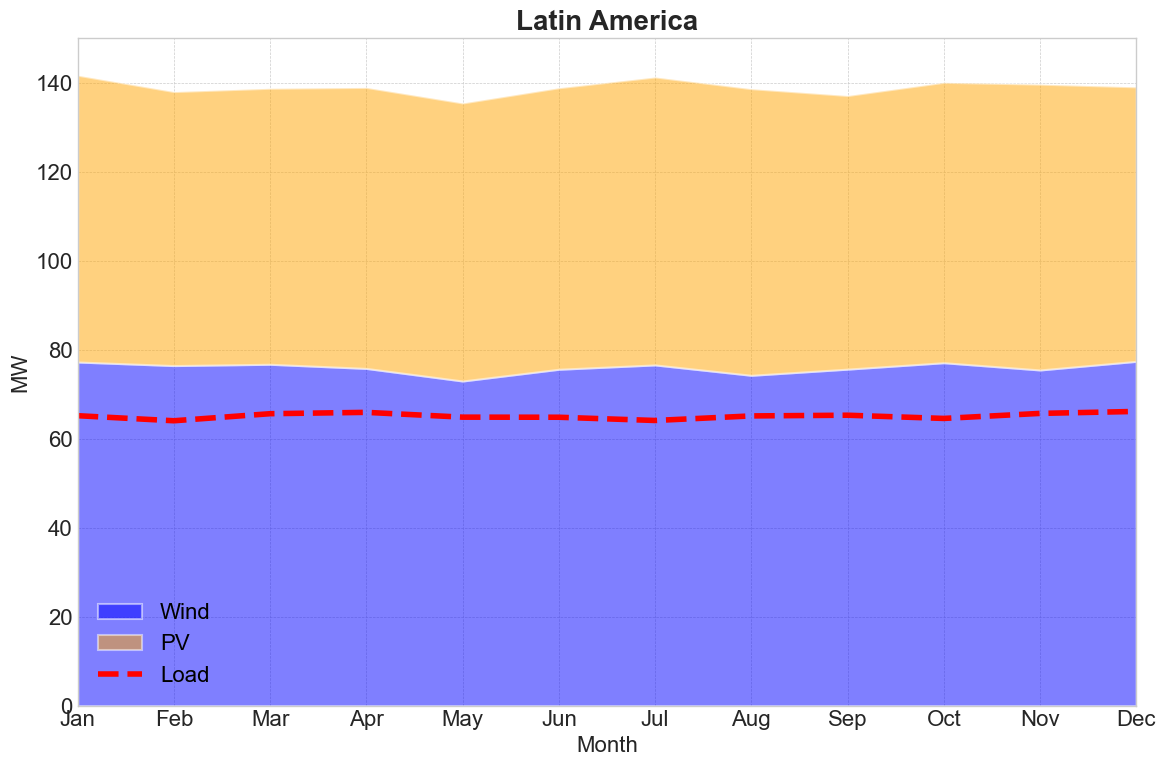

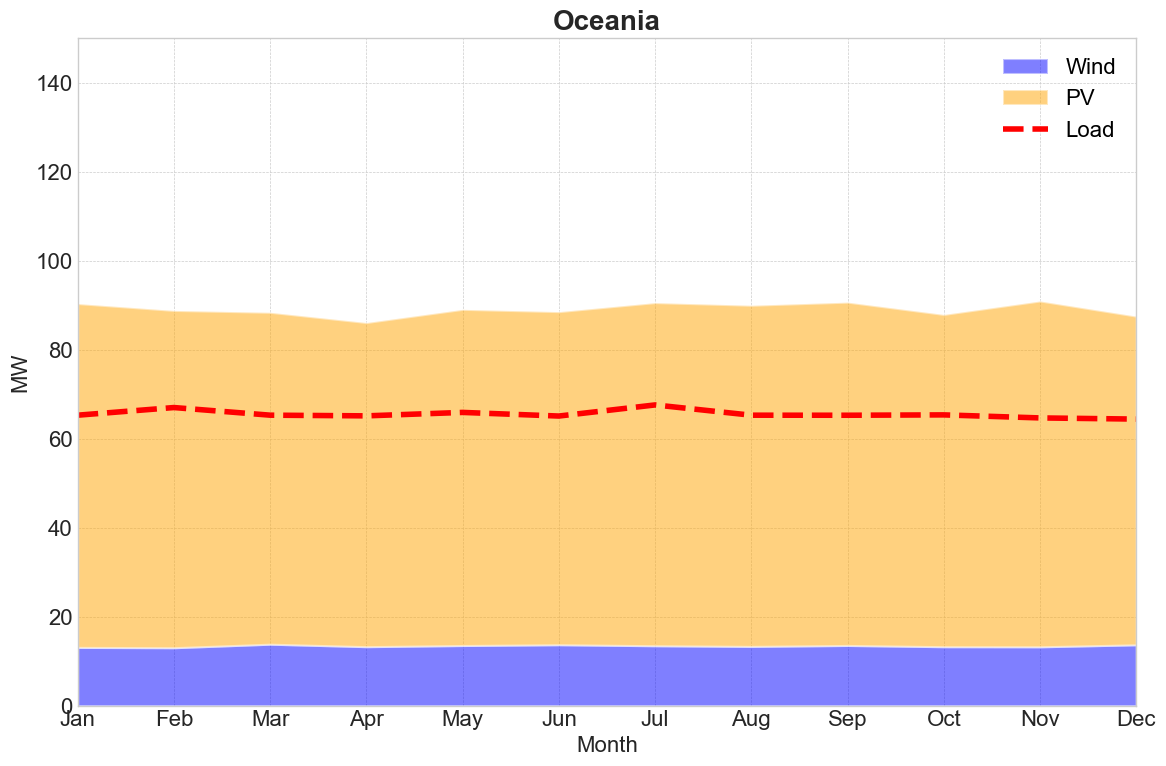

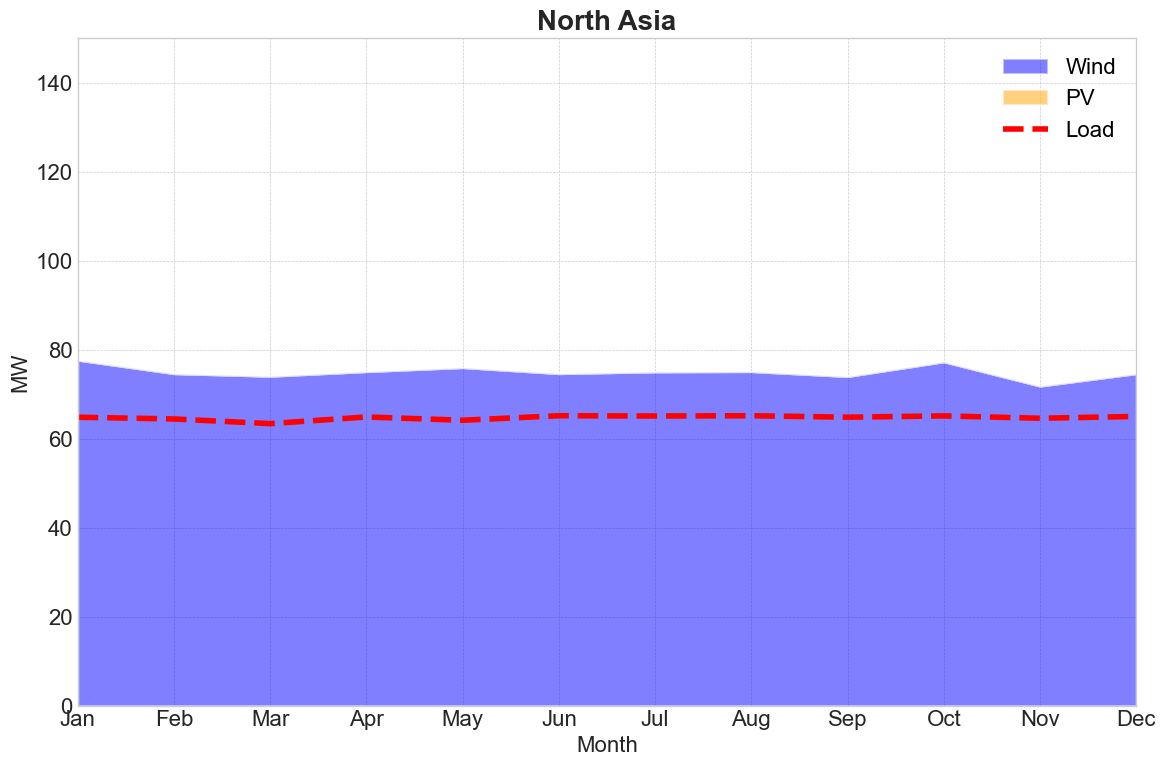

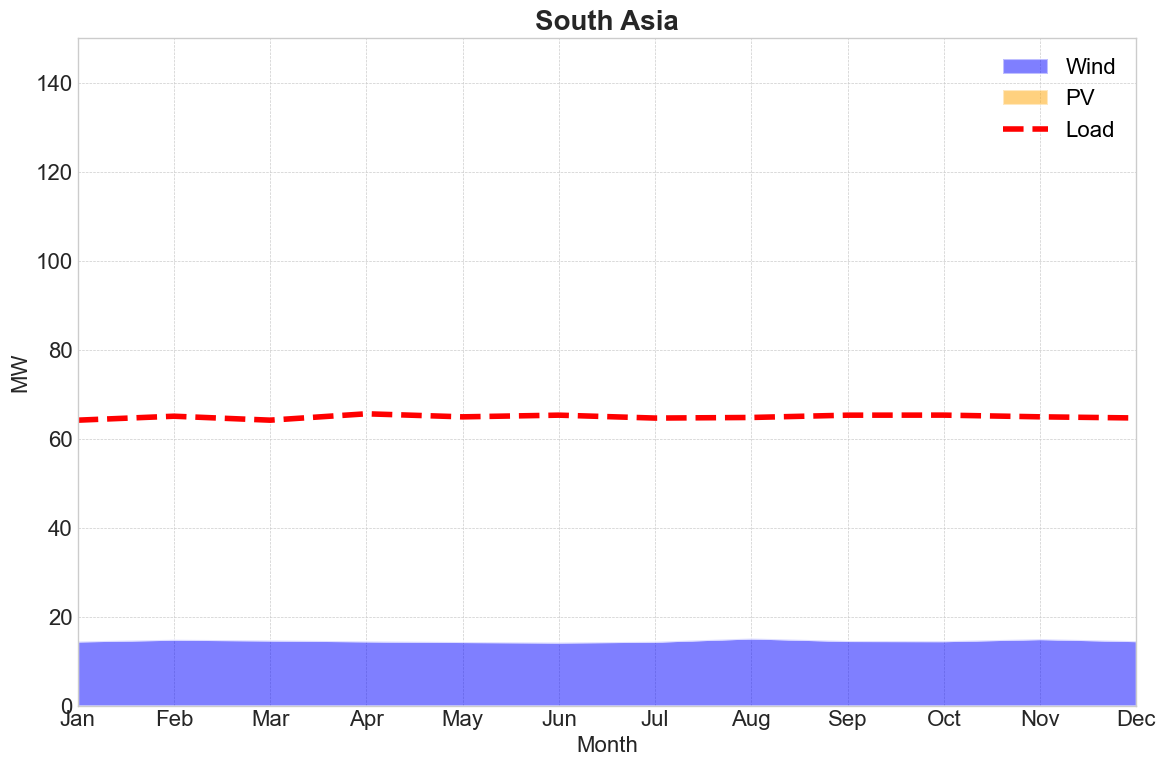

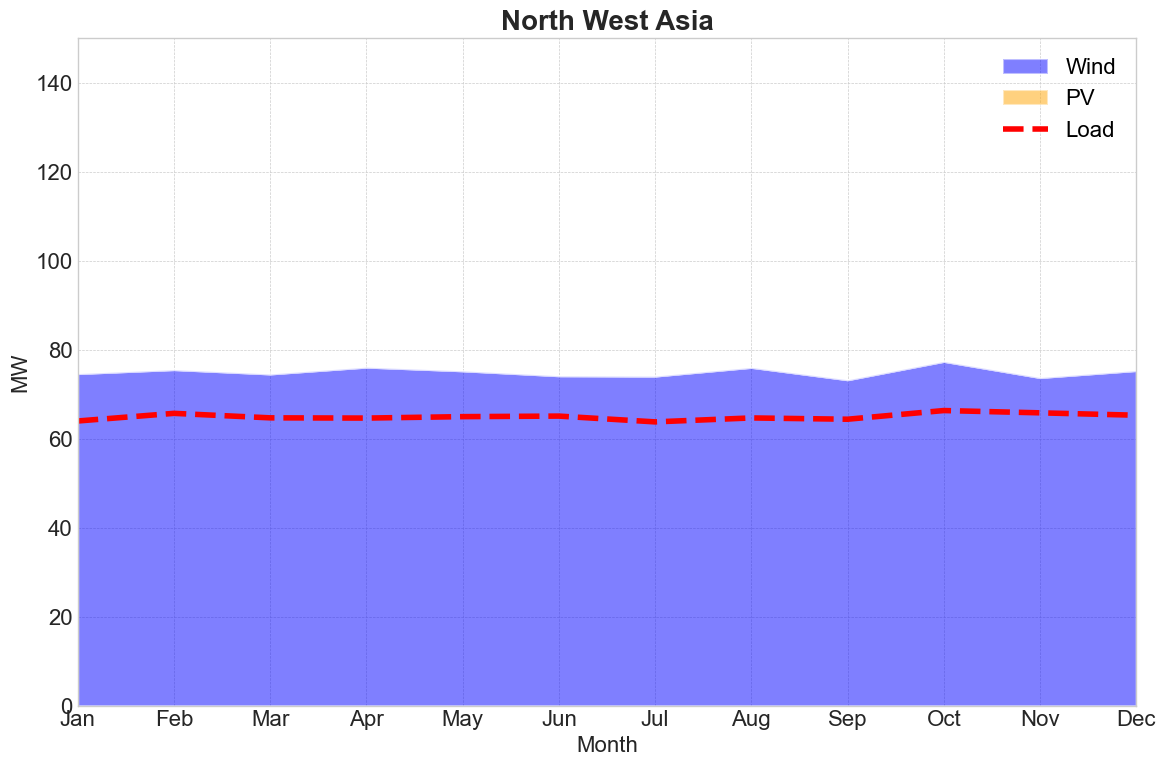

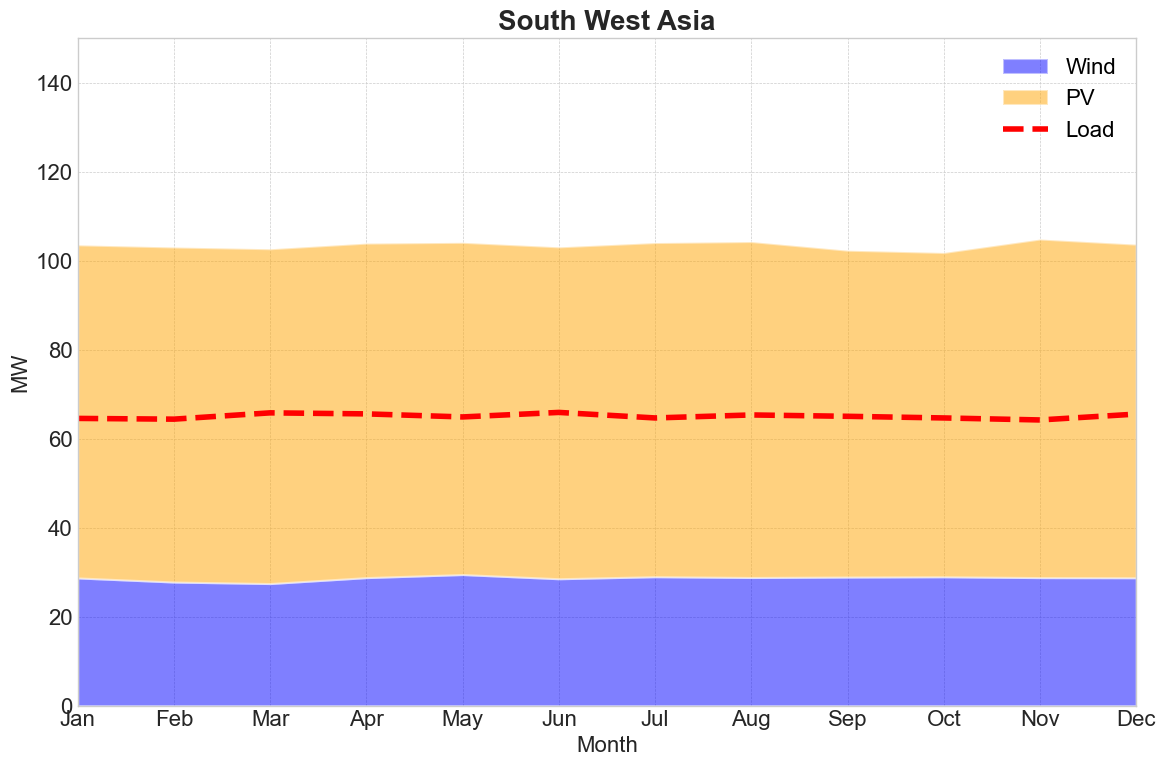

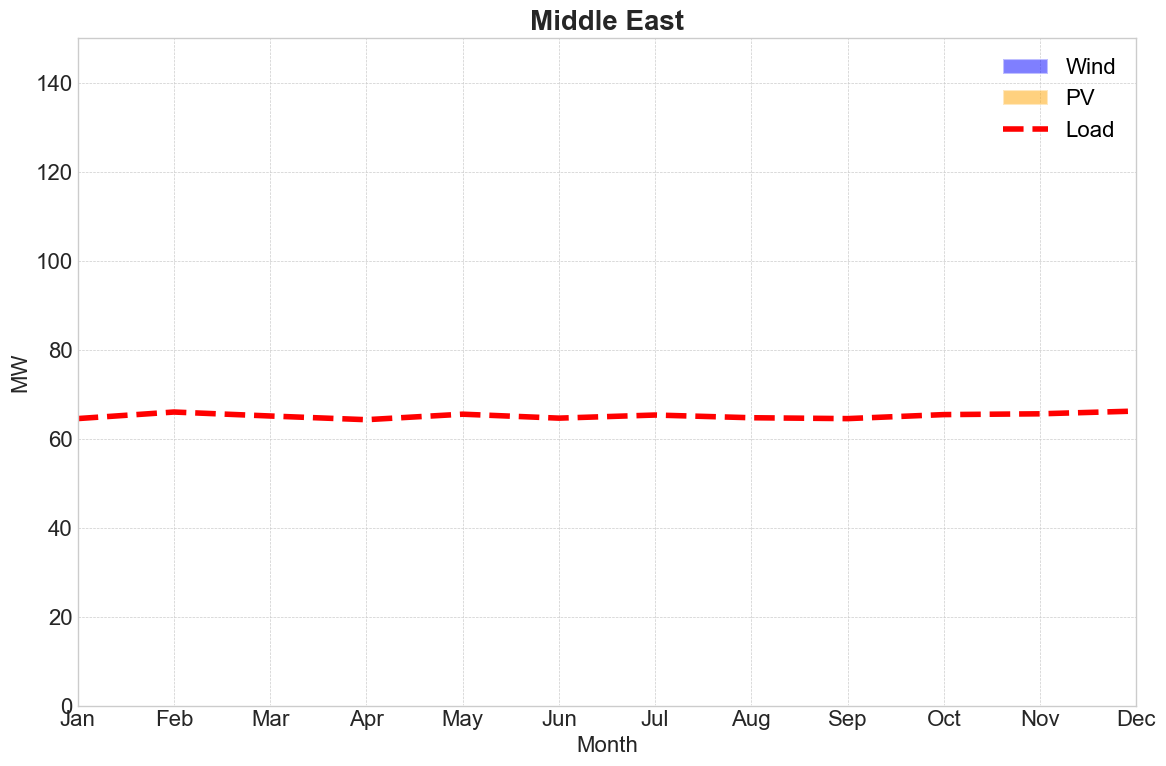

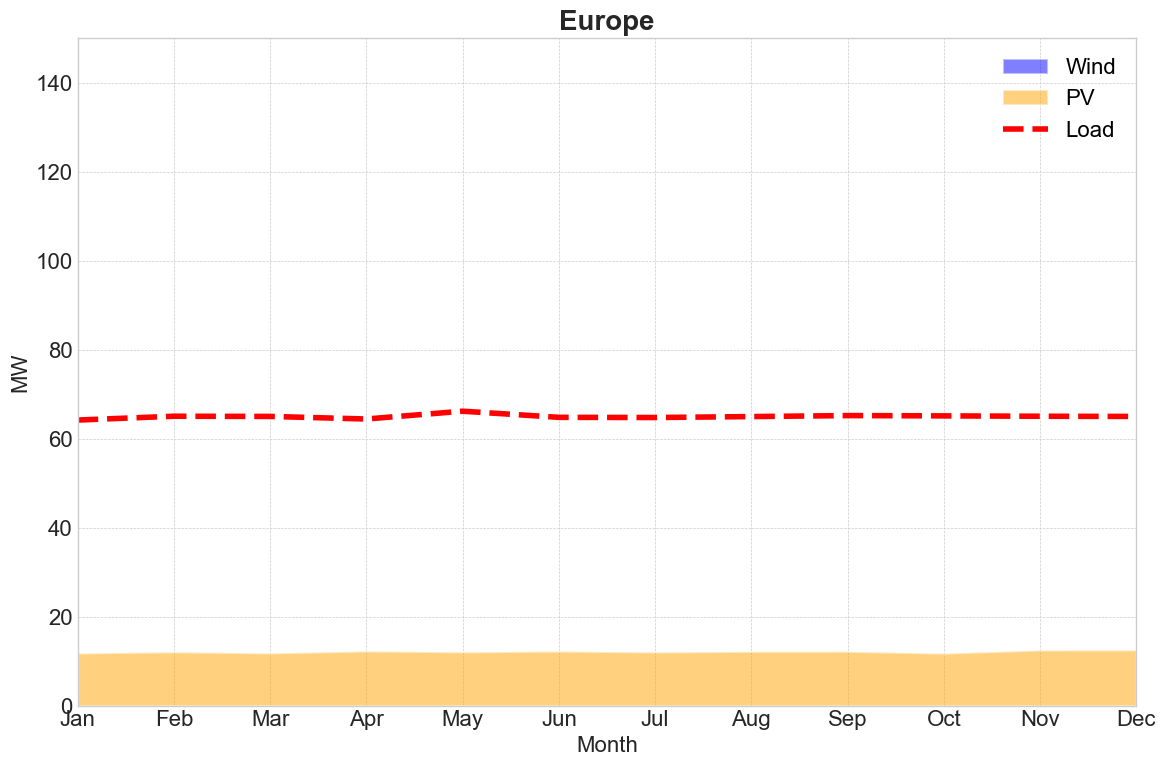

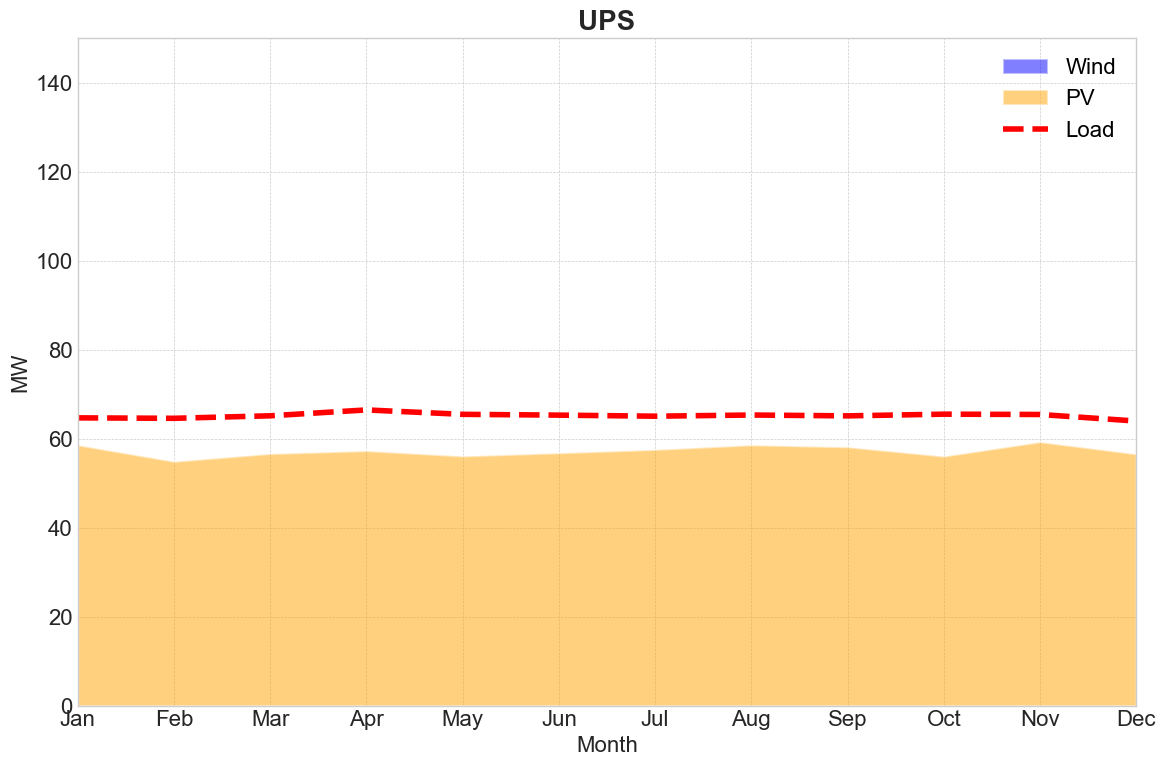

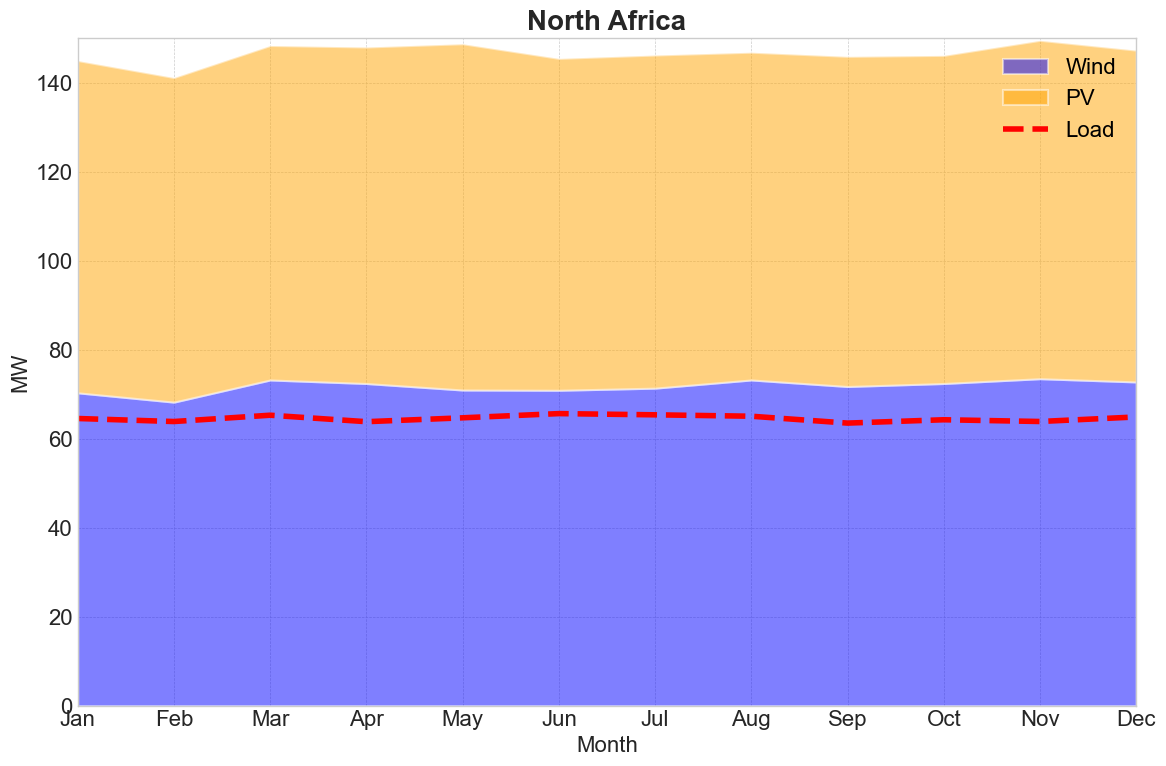

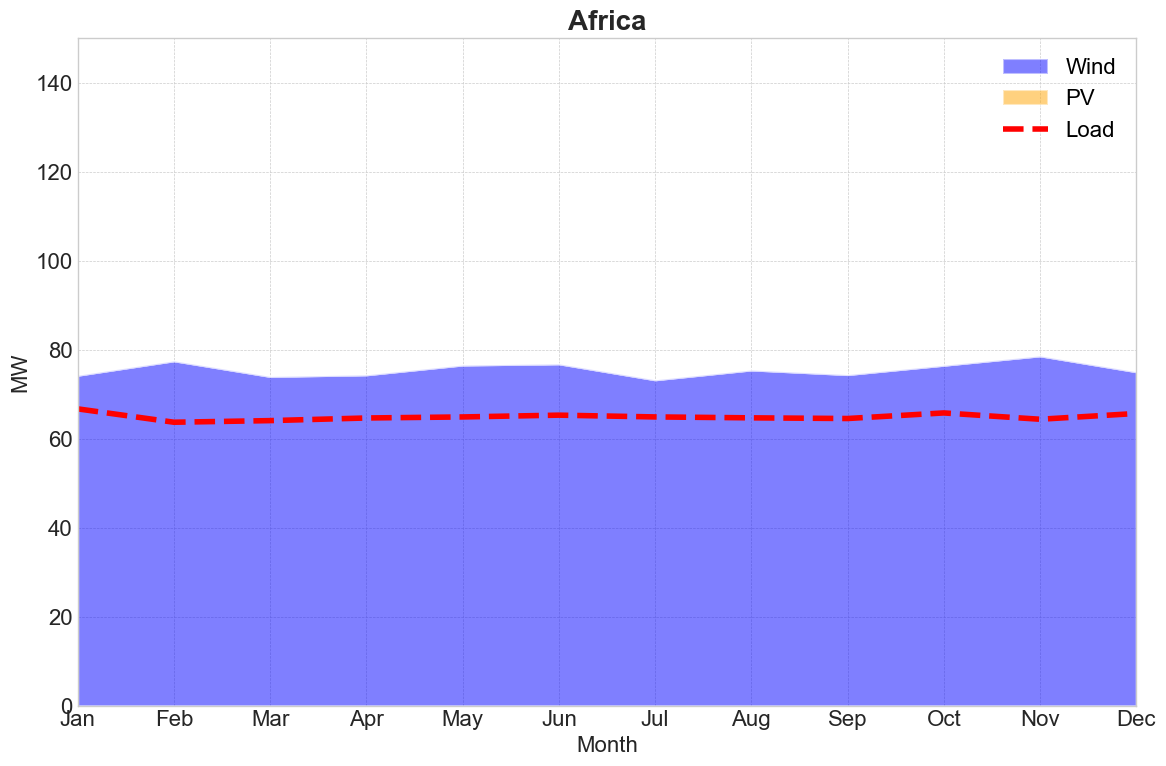

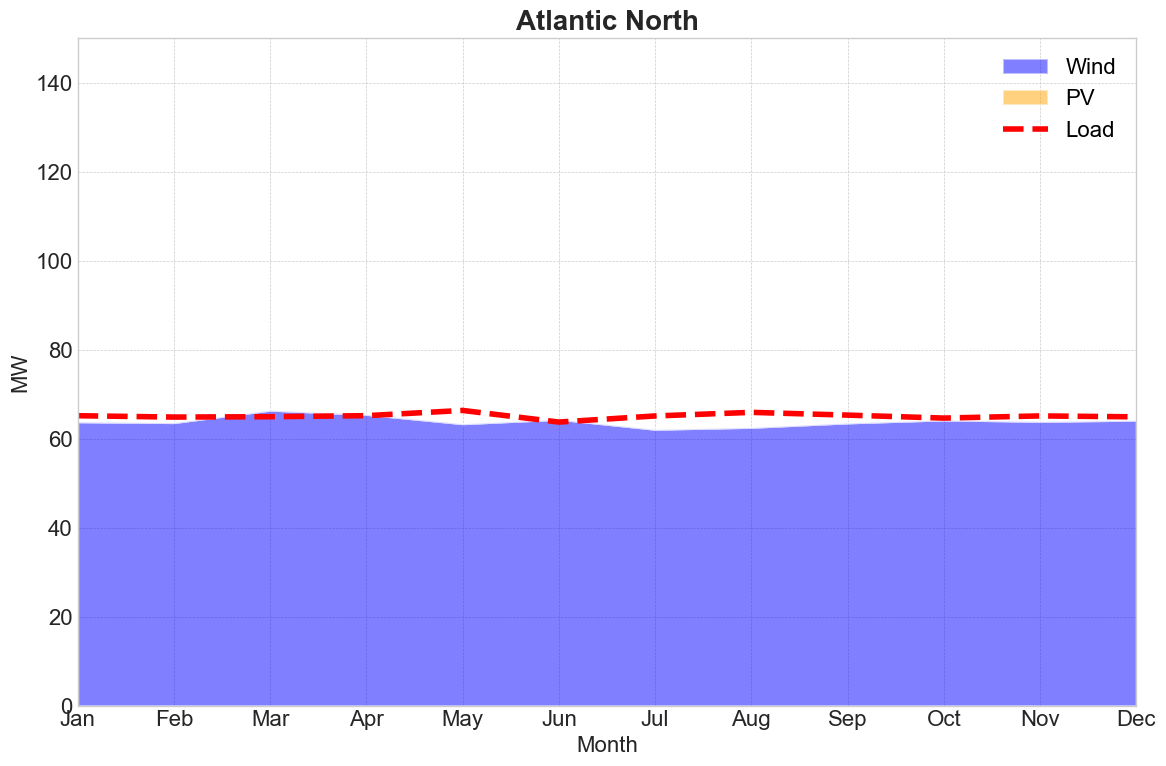

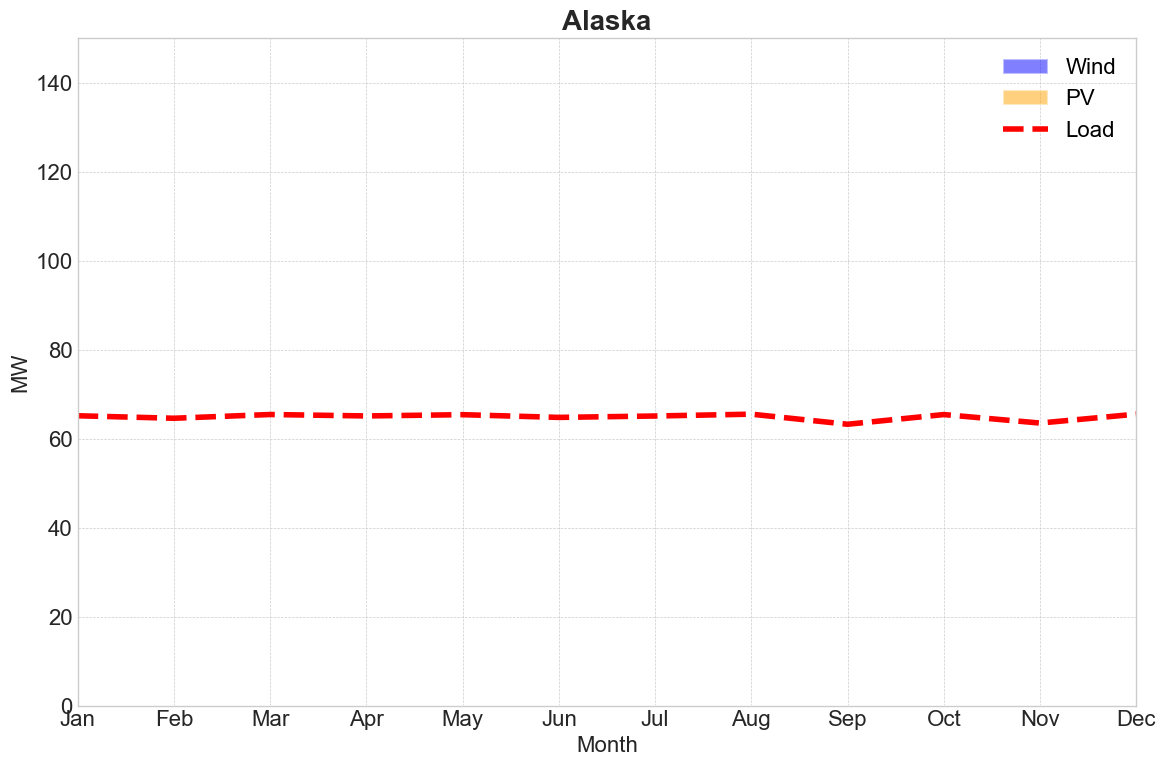

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Set the style and context for Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')  # Use a clean and white grid style

for key, value in regions_dic.items():
    load = value["mean_load_monthly"]
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{value["region"]}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    plt.xlim(1,12)
    plt.ylim(0,150)
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()


## Plotting of losses

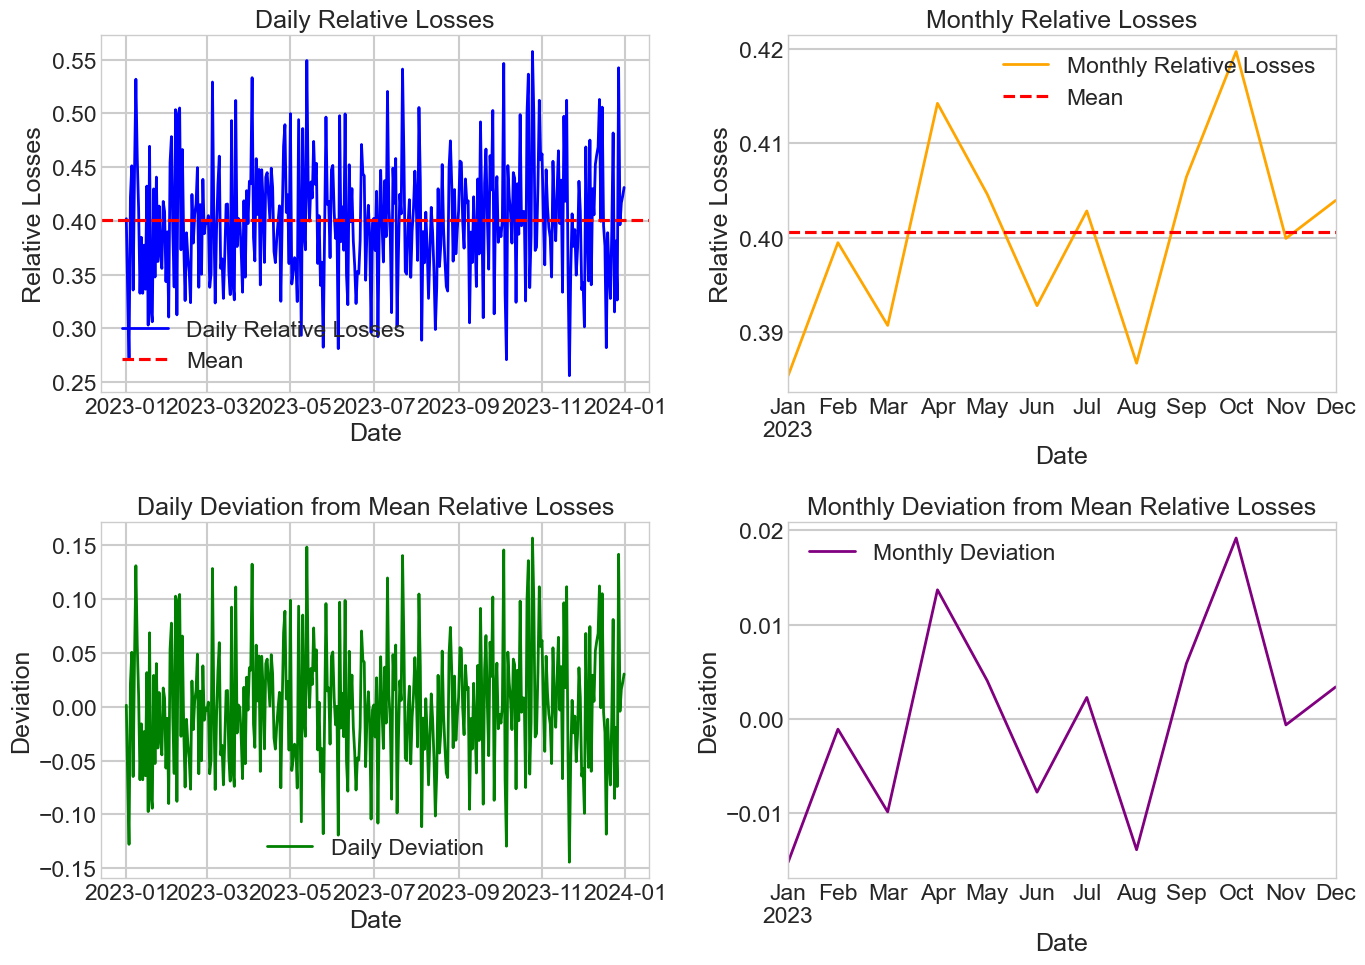

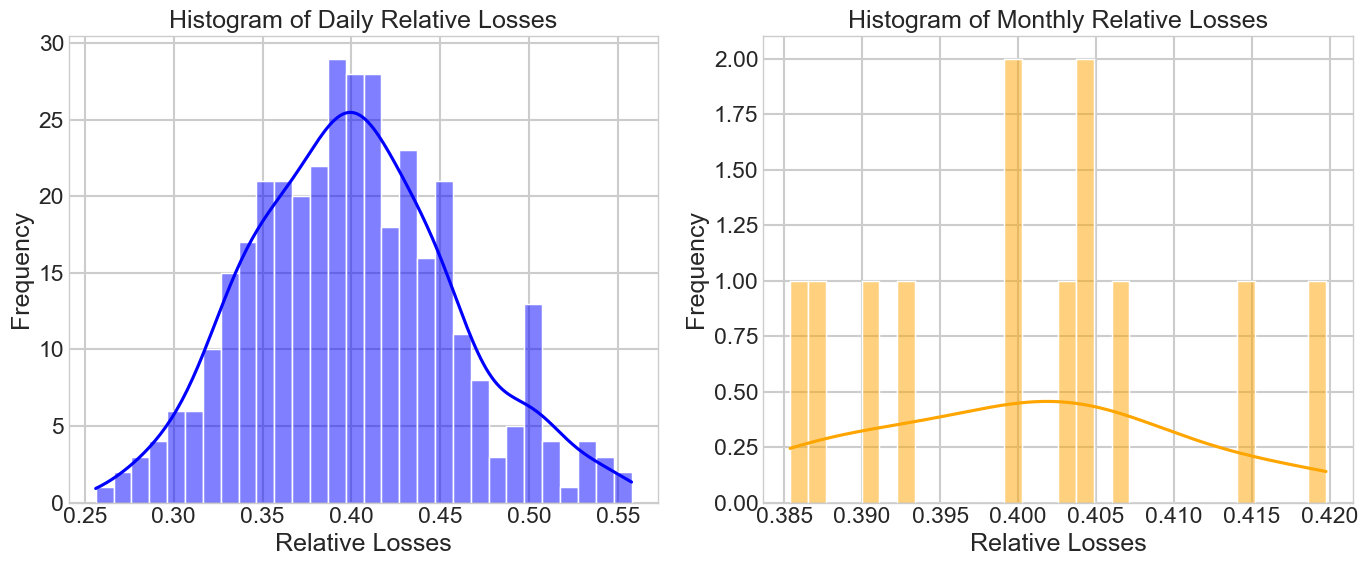

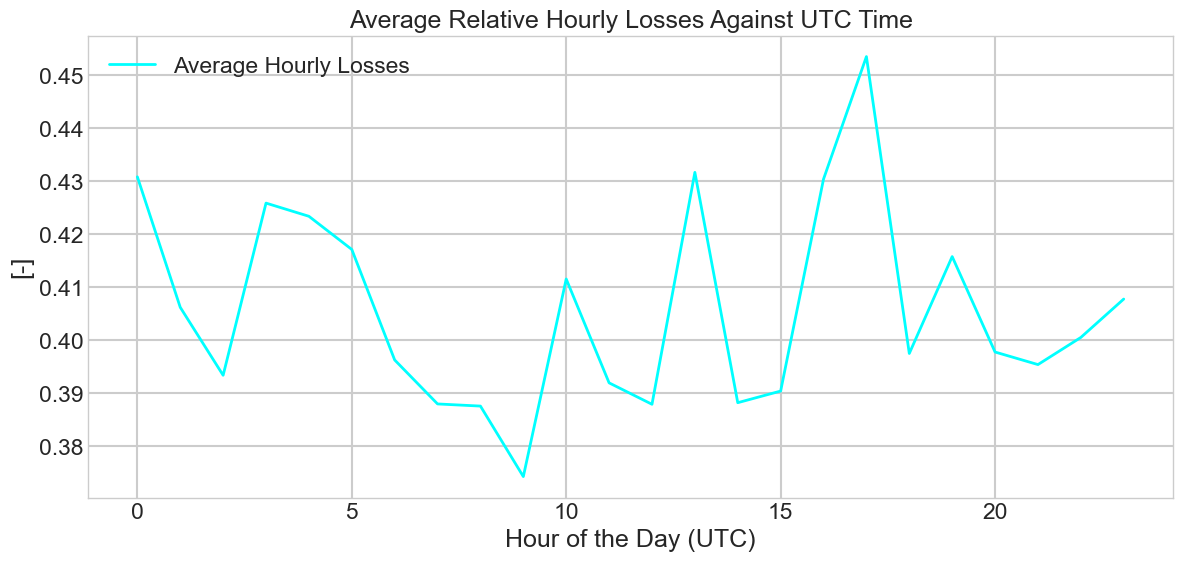

In [ ]:
# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))

# Daily Relative Losses
plt.subplot(2, 2, 1)
daily_losses_rel_to_gen.plot(label='Daily Relative Losses', color='blue', linewidth=2)
plt.axhline(y=daily_losses_rel_to_gen.mean(), color='red', linestyle='--', label='Mean')
plt.title('Daily Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_gen.plot(label='Monthly Relative Losses', color='orange', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_gen.mean(), color='red', linestyle='--', label='Mean')
plt.title('Monthly Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Daily Deviation
plt.subplot(2, 2, 3)
daily_deviation_gen.plot(label='Daily Deviation', color='green', linewidth=2)
plt.title('Daily Deviation from Mean Relative Losses')
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.legend()

# Monthly Deviation
plt.subplot(2, 2, 4)
monthly_deviation_gen.plot(label='Monthly Deviation', color='purple', linewidth=2)
plt.title('Monthly Deviation from Mean Relative Losses')
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.legend()

plt.tight_layout()
plt.show()

# Histogram of Daily and Monthly Relative Losses
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(daily_losses_rel_to_gen, bins=30, kde=True, color='blue')
plt.title('Histogram of Daily Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(monthly_losses_rel_to_gen, bins=30, kde=True, color='orange')
plt.title('Histogram of Monthly Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Losses against UTC time
hourly_losses = hourly_losses_rel_to_gen.groupby(hourly_losses_rel_to_gen.index.hour).mean()
plt.figure(figsize=(14, 6))
hourly_losses.plot(label='Average Hourly Losses', color='cyan', linewidth=2)
plt.title('Average Relative Hourly Losses Against UTC Time')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('[-]')
plt.legend()
plt.show()


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/697929328.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


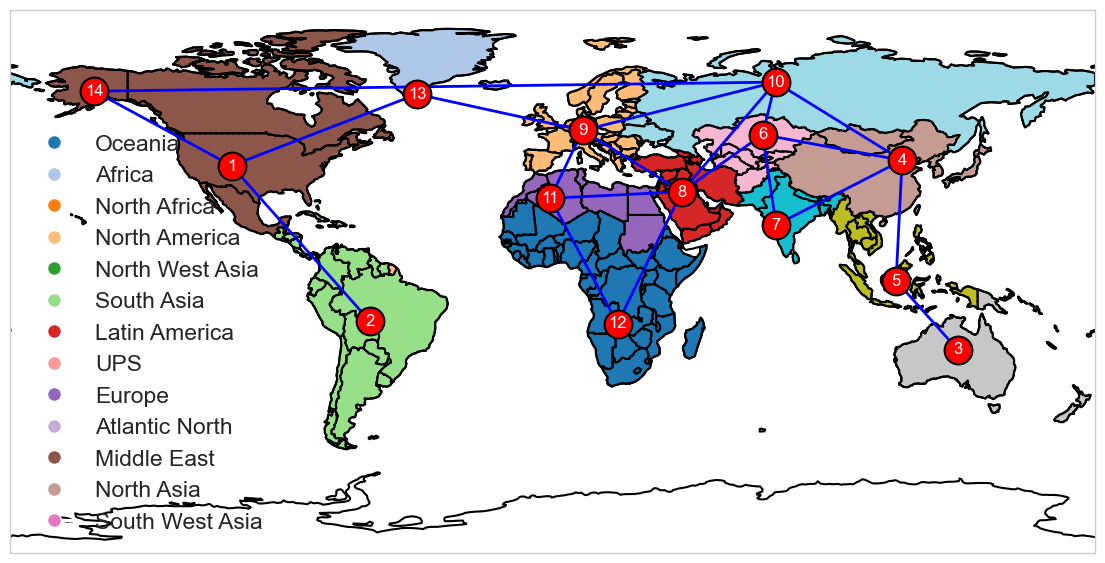

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Plot links
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]
    ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/1551578859.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


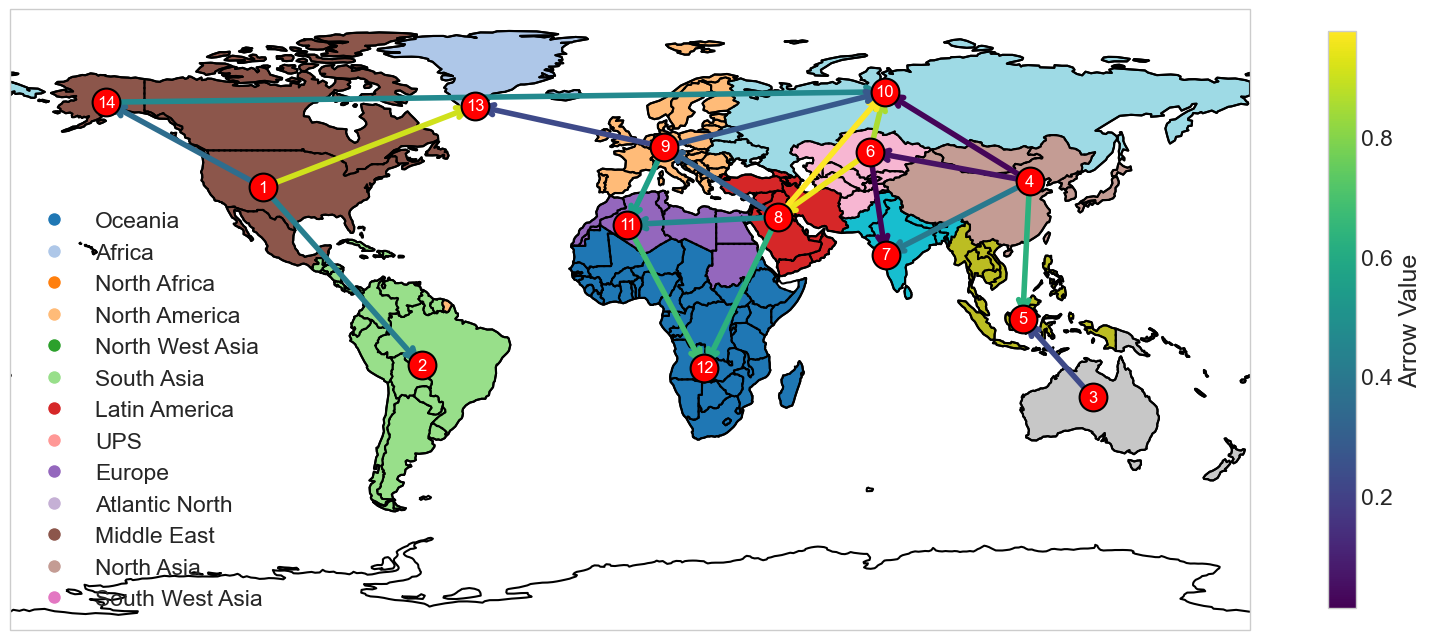

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in globalgrid.links.index}  # Example boolean data for direction
arrow_colors = {link: np.random.random() for link in globalgrid.links.index}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.viridis

# Plot links with directional arrows and heatmap colors
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]
    
    # Determine the direction of the arrow
    if arrow_directions[link]:
        start, end = (x0, y0), (x1, y1)
    else:
        start, end = (x1, y1), (x0, y0)
    
    # Determine the color of the arrow
    color = cmap(norm(arrow_colors[link]))
    
    # Plot the arrow
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=4))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Arrow Value')

plt.show()


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/437460935.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


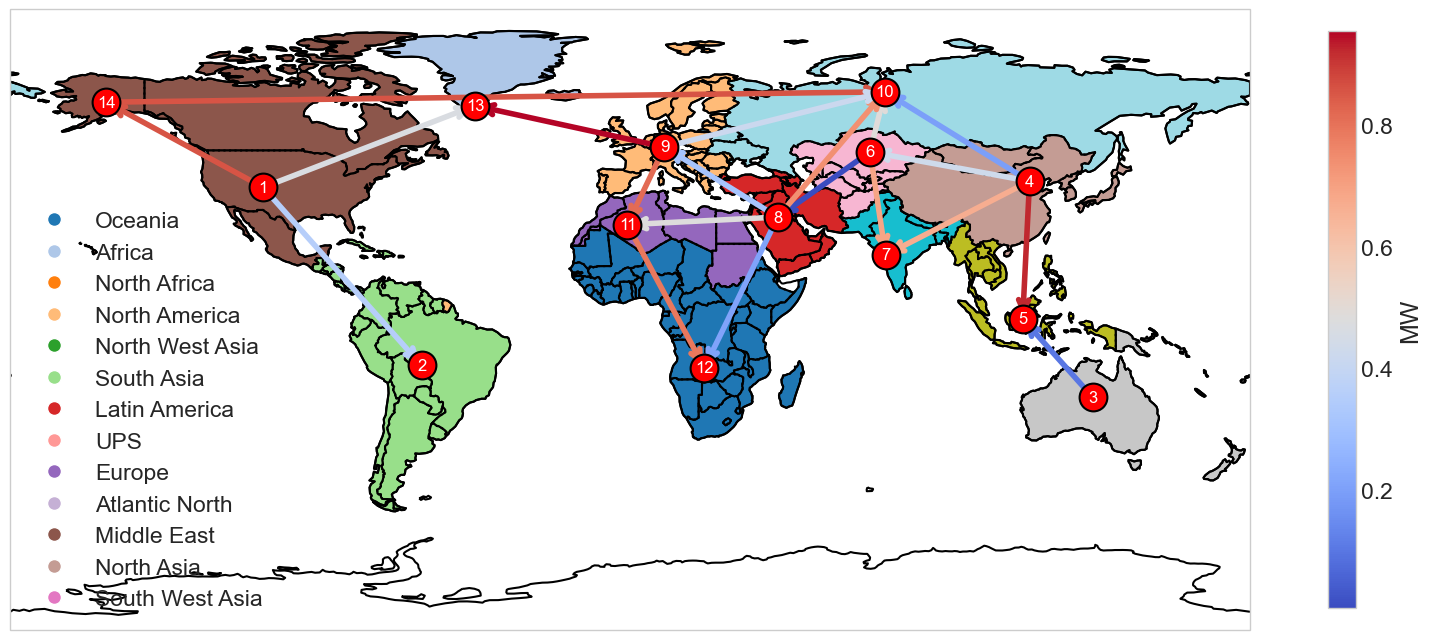

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in globalgrid.links.index}  # Example boolean data for direction
arrow_colors = {link: np.random.random() for link in globalgrid.links.index}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.coolwarm

# Plot links with directional arrows and heatmap colors
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]
    
    # Determine the direction of the arrow
    if arrow_directions[link]:
        start, end = (x0, y0), (x1, y1)
    else:
        start, end = (x1, y1), (x0, y0)
    
    # Determine the color of the arrow
    color = cmap(norm(arrow_colors[link]))
    
    # Plot the arrow
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=4))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/2010562649.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


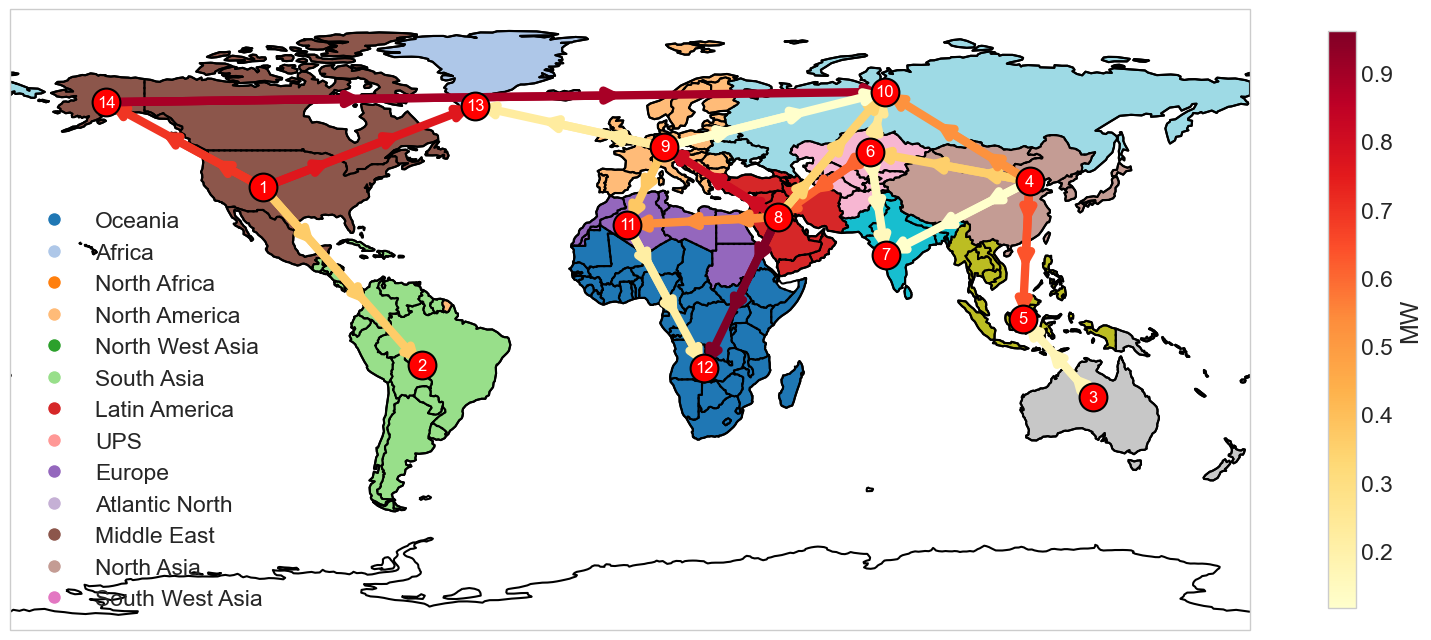

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in globalgrid.links.index}  # Example boolean data for direction
arrow_colors = {link: np.random.random() for link in globalgrid.links.index}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.YlOrRd

# Function to calculate points at fractions of the distance along a line
def interpolate_points(x0, y0, x1, y1, fraction):
    x = x0 + fraction * (x1 - x0)
    y = y0 + fraction * (y1 - y0)
    return x, y

# Plot links with directional arrows and heatmap colors
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]
    
    # Determine the color of the arrow
    color = cmap(norm(arrow_colors[link]))
    
    # Calculate positions for the arrows at 1/3, 2/3, and 3/3 points along the line
    x_1_3, y_1_3 = interpolate_points(x0, y0, x1, y1, 1/3)
    x_2_3, y_2_3 = interpolate_points(x0, y0, x1, y1, 2/3)
    x_3_3, y_3_3 = interpolate_points(x0, y0, x1, y1, 1.0)
    
    # Determine the direction of the arrow
    if arrow_directions[link]:
        start_1_3, end_1_3 = (x0, y0), (x_1_3, y_1_3)
        start_2_3, end_2_3 = (x0, y0), (x_2_3, y_2_3)
        start_3_3, end_3_3 = (x0, y0), (x_3_3, y_3_3)
    else:
        start_1_3, end_1_3 = (x1, y1), (x_1_3, y_1_3)
        start_2_3, end_2_3 = (x1, y1), (x_2_3, y_2_3)
        start_3_3, end_3_3 = (x1, y1), (x_3_3, y_3_3)
    
    # Plot the arrows
    ax.annotate('', xy=end_1_3, xytext=start_1_3,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=6))
    ax.annotate('', xy=end_2_3, xytext=start_2_3,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=6))
    ax.annotate('', xy=end_3_3, xytext=start_3_3,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=6))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/1885626021.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


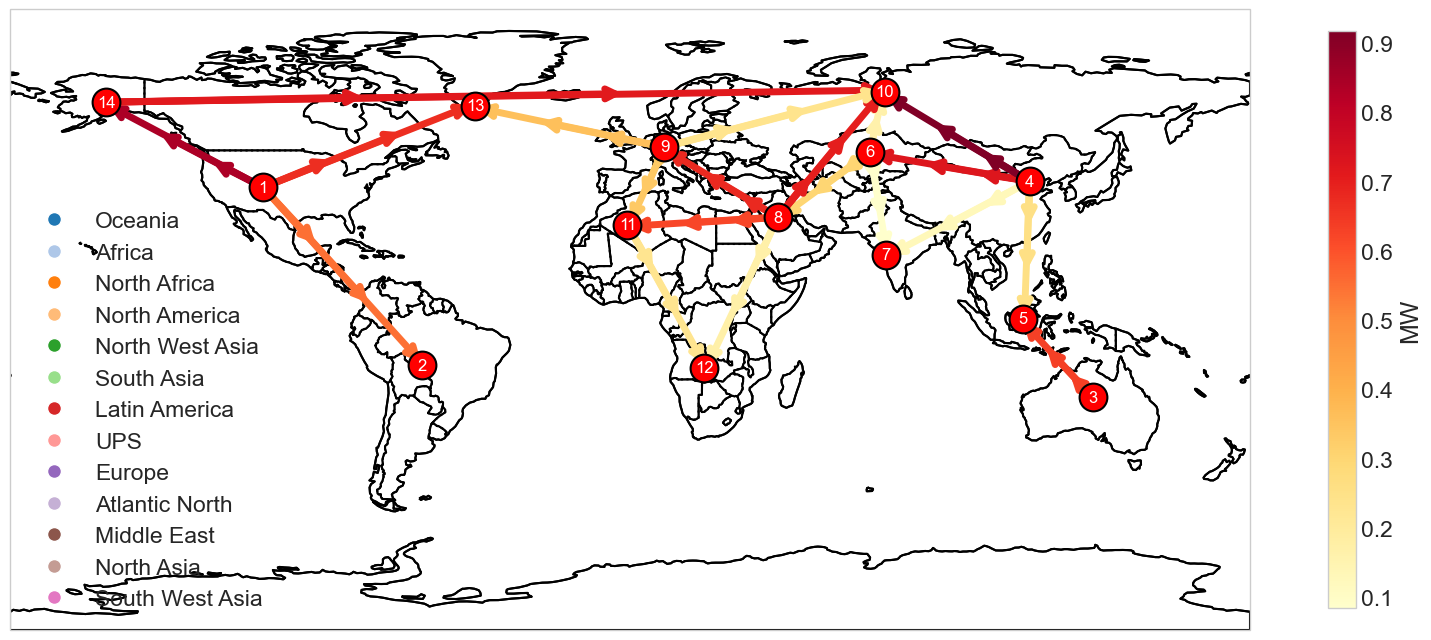

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend, setting facecolor to white
world.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())
world.plot(ax=ax, color='white', edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in globalgrid.links.index}  # Example boolean data for direction
arrow_colors = {link: np.random.random() for link in globalgrid.links.index}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.YlOrRd

# Function to calculate offset coordinates
def offset_coordinates(x0, y0, x1, y1, offset):
    dx, dy = x1 - x0, y1 - y0
    length = np.sqrt(dx**2 + dy**2)
    offset_x = -offset * dy / length
    offset_y = offset * dx / length
    return offset_x, offset_y

# Plot links with directional arrows and heatmap colors at 1/3, 2/3, and 3/3 points
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]
    
    offset_x, offset_y = offset_coordinates(x0, y0, x1, y1, 0.5)  # Adjust offset as needed
    
    # Calculate points at 1/3, 2/3, and 3/3 of the way along the line
    points = [
        (x0 + (x1 - x0) / 3 + offset_x, y0 + (y1 - y0) / 3 + offset_y),
        (x0 + 2 * (x1 - x0) / 3 + offset_x, y0 + 2 * (y1 - y0) / 3 + offset_y),
        (x1 + offset_x, y1 + offset_y)
    ]
    
    for point in points:
        # Determine the direction of the arrow
        if arrow_directions[link]:
            start, end = (x0, y0), point
        else:
            start, end = (x1, y1), point
        
        # Determine the color of the arrow
        color = cmap(norm(arrow_colors[link]))
        
        # Plot the arrow
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', color=color, linewidth=5))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()
